motif: GCTCA


/tmp/ipykernel_146832/3107423636.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_146832/3107423636.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


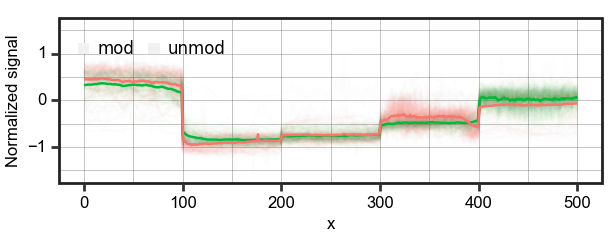

/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3.04 x 1.22 in image.
/home/wuyou/.conda/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figure/figure_1c_signal_difference_between_U_and_psU.pdf


In [4]:
#signal diff plot

from scipy import interpolate
import traceback
#import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import re
import numpy as np
from statsmodels import robust

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"


def interp(x):
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/paper/data/ELIGOS.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:]
        else:
            seq=line
            ref_dict[chr]=seq


ref_chr="U2"
site=365
normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]
print("motif:",motif)

X=[]
X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/paper/ELIGOS_normalU/normalU.signal.tsv",
              "/home/wuyou/Projects/paper/ELIGOS_psU/psU.signal.tsv"]

label_dict={0:"U",1:"mod"}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)



            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):                                 #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X.append(x)
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
                
mean1=pd.DataFrame(np.mean(np.array(X[0:101]),axis=0))               
mean1["value"]=pd.DataFrame(np.mean(np.array(X[0:101]),axis=0))             
mean1["x"]=np.linspace(0,500,500)
mean2=pd.DataFrame(np.mean(np.array(X[101:202]),axis=0))   
mean2["value"]=pd.DataFrame(np.mean(np.array(X[101:202]),axis=0))             
mean2["x"]=np.linspace(0,500,500)              

data=pd.DataFrame(np.transpose(X))
#data["label"]=Y

data["x"]=np.linspace(0,500,500)

data=pd.melt(data,id_vars=["x"])

data_unmod=data[data["variable"]<101]
data_mod=data[data["variable"]>=101]

data_unmod["label"]=["unmod"]*len(data_unmod)
data_mod["label"]=["mod"]*len(data_mod)
data=pd.concat([data_mod,data_unmod])


p2=(ggplot(data,aes(x="x",y="value"))
    +geom_line(data,aes(x="x",y="value",group="variable",fill="label",color="label"),alpha=0.01)
    #+geom_line(data_unmod,aes(x="x",y="value",group="variable"),alpha=0.05,color="black")
    +geom_line(mean1,aes(x="x",y="value"),color=c2,alpha=1)
    +geom_line(mean2,aes(x="x",y="value"),color=c1,alpha=1)
    +theme(
        figure_size=[3.04,1.22],
        axis_text=element_text(size=6,family="Arial",color="black"),
        axis_title_x=element_text(size=6,family="Arial",color="black"),
        axis_title_y=element_text(size=6,family="Arial",color="black"),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6,alpha=1),
        legend_background=element_rect(size=0.5,alpha=0),
        legend_position=(0.25,0.85), 
        legend_key=element_rect(alpha=1),
        legend_key_size=4) #change legend text font size))
    +labs(y = "Normalized signal")
    +scale_color_manual(values=[c1, c2]) 
    +ylim([-1.6,1.6])
    
   )    
print(p2)


p2.save('figure/figure_1c_signal_difference_between_U_and_psU.pdf')